# Loading packages and data

In [1]:
import numpy as np
import itertools
import random
import csv
import sys
import os
import string
import copy
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
with_outliers = False
reference_1b = True
controls_only = True
raw_data = True

In [3]:
def visualise_from_list(visualisation_dictionnary, 
                        folder = "duplicates", 
                        distance= "raw", 
                        addition = "",
                        export_stats = False):
    column_original = visualisation_dictionnary["original_list"]
    column_repeated = visualisation_dictionnary["repeated_list"]
    column_original_sd = visualisation_dictionnary["error_original_list"]
    column_repeated_sd = visualisation_dictionnary["error_repeated_list"]
    name_original = visualisation_dictionnary["name_original"]
    name_repeated = visualisation_dictionnary["name_repeated"]
    annotations = visualisation_dictionnary["annotations"]
    
    fig, ax = plt.subplots()
    ax.scatter(column_original,column_repeated)
    
    r2 = r2_score(column_original, column_repeated)
    ax.errorbar(column_original, column_repeated, xerr=column_original_sd, yerr=column_repeated_sd, ls='none', ecolor = None)
    ax.set_title('Plates {} and {}: r2 of {}'.format(name_original, name_repeated, r2))
    name_for_plotting = folder + "/duplicated_{}_{}_".format(name_original, name_repeated) + distance + addition + '.png'
    ax.set_xlabel("Original: {}".format(name_original))
    ax.set_ylabel("Repeated: {}".format(name_repeated))
    range_line_min = max(max(column_original), max(column_repeated))
    range_line_max = min(min(column_original), min(column_repeated))
    plt.plot([range_line_min, range_line_max],[range_line_min,range_line_max])
    if distance == "raw":
        for i in range(len(column_original)):
            ax.annotate(s = annotations[i], size=12, 
                        xy = (column_original[i], column_repeated[i]),
                        xytext=(column_original[i] + 40, column_repeated[i] + 10))
    else:
         for i in range(len(column_original)):
            ax.annotate(s = annotations[i], size=12, 
                        xy = (column_original[i], column_repeated[i]),
                        xytext=(column_original[i] + 0.01, column_repeated[i] + 0.01))               
    plt.savefig(name_for_plotting)
    if export_stats:
        return(r2)
    # plt.show()

In [4]:
def visualise_from_list_with_reg(visualisation_dictionnary, folder = "original_data", distance= "raw", addition = ''):
    column_original = visualisation_dictionnary["original_list"]
    column_repeated = visualisation_dictionnary["repeated_list"]
    column_original_sd = visualisation_dictionnary["error_original_list"]
    column_repeated_sd = visualisation_dictionnary["error_repeated_list"]
    name_original = visualisation_dictionnary["name_original"]
    name_repeated = visualisation_dictionnary["name_repeated"]
    annotations = visualisation_dictionnary["annotations"]
    X = np.array(column_original)
    y = np.array(column_repeated)
    linear_reg = sklearn.linear_model.LinearRegression()
    linear_reg.fit(X.reshape(-1, 1),y.reshape(-1, 1))  
    y_pred = linear_reg.predict(X.reshape(-1, 1))
    r2 = r2_score(y, y_pred)
    a = float(linear_reg.coef_[[0]])
    b = float(linear_reg.intercept_[[0]])
    fig, ax = plt.subplots()
    ax.scatter(column_original,column_repeated)
    ax.errorbar(column_original, column_repeated, xerr=column_original_sd, yerr=column_repeated_sd, ls='none', ecolor = None)
    ax.set_title('Plates {} and {}'.format(name_original, name_repeated))
    name_for_plotting = folder + "/regression_{}_{}_".format(name_original, name_repeated) + distance + addition +'.png'
    ax.set_xlabel("Original: {}".format(name_original))
    ax.set_ylabel("Repeated: {}".format(name_repeated))
    plt.suptitle("R2 {}, with a: {} and b: {}".format(round(r2, 2), round(a, 2), round(b, 2)),fontsize=10)
    plt.plot(X, y_pred, color='black')
    # plt.plot([range_line_min, range_line_max],[a * range_line_min+b ,a * range_line_max+b])
    if distance == "raw":
        for i in range(len(column_original)):
            ax.annotate(s = annotations[i], size=12, 
                        xy = (column_original[i], column_repeated[i]),
                        xytext=(column_original[i] + 40, column_repeated[i] + 10))
    else:
         for i in range(len(column_original)):
            ax.annotate(s = annotations[i], size=12, 
                        xy = (column_original[i], column_repeated[i]),
                        xytext=(column_original[i] + 0.01, column_repeated[i] + 0.01))               
    plt.savefig(name_for_plotting)
    # plt.show()
    return(a, b)

In [5]:
array_compare_yields = "all_duplicates_yields.csv"

# All data loading

In [6]:
all_data_yields = {}

In [7]:
with open(array_compare_yields, "r") as reader:
    csv_reader = csv.DictReader(reader)
    for row in csv_reader:
        ori_plate = row["original_plate"]
        rep_plate = row["repeated_plate"]
        # Creating the plate
        duplication = "{}_{}".format(ori_plate, rep_plate)
        if not duplication in all_data_yields.keys():
            all_data_yields[duplication] = {"name_original": ori_plate, "name_repeated": rep_plate}
        # Original list
        if "original_list" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["original_list"].append(float(row["Mean_original"]))
        else:
            all_data_yields[duplication]["original_list"] = [float(row["Mean_original"])]
        # Repeated list
        if "repeated_list" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["repeated_list"].append(float(row["Mean_repeated"]))
        else:
            all_data_yields[duplication]["repeated_list"] = [float(row["Mean_repeated"])]    
        # Errors original list
        if "error_original_list" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["error_original_list"].append(float(row["Std_original"]))
        else:
            all_data_yields[duplication]["error_original_list"] = [float(row["Std_original"])]    
        # Errors repeated list
        if "error_repeated_list" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["error_repeated_list"].append(float(row["Std_repeated"]))
        else:
            all_data_yields[duplication]["error_repeated_list"] = [float(row["Std_repeated"])]
        # Annotations list
        annotation = "{}_{}".format(row["Name_original"], row["Name_repeated"])
        if "annotations" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["annotations"].append(annotation)
        else:
            all_data_yields[duplication]["annotations"] = [annotation]
        concentrations_as_dict = {"nad": row["nad"], "folinic_acid": row["folinic_acid"], "DNA": row["DNA"], 
                                  "coa" : row["coa"], "peg": row["peg"], "RBS": row["RBS"], "nucleo_mix": row["nucleo_mix"],
                                  "spermidin": row["spermidin"], "pga": row["pga"], "aa": row["aa"], "trna": row["trna"],
                                  "mg_gluta": row["mg_gluta"], "hepes": row["hepes"], "camp": row["camp"], 
                                  "K_gluta": row["K_gluta"], "promoter": row["promoter"]
        }
        if "concentrations_as_dict" in all_data_yields[duplication].keys():
             all_data_yields[duplication]["concentrations_as_dict"].append(concentrations_as_dict)
        else:
            all_data_yields[duplication]["concentrations_as_dict"] = [concentrations_as_dict]

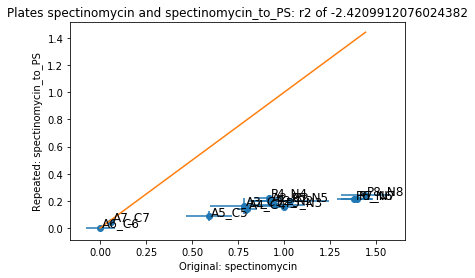

In [8]:
original_yield_scores = {"Strategy": "original-yields"}
original_raw_scores = {"Strategy": "original"}
for duplications in all_data_yields.keys():
    r2 = visualise_from_list(all_data_yields[duplications], distance = "yield", export_stats= True)
    original_yield_scores[duplications] = r2

In [9]:
folder_name = 'analyse_regressions'

0.1499460079493265 0.02765877280993942


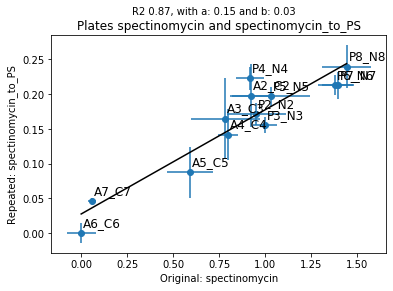

In [10]:
a, b = visualise_from_list_with_reg(all_data_yields["spectinomycin_spectinomycin_to_PS"],distance = "yield", folder = folder_name, addition = "reg_ref")
print(a,b)